In [1]:
# Big Data and Economics Group Project: Predicting the outcome of the Brexit Referendum
# Sean O'Donohoe, Horace Kwan, Teng Loi

In [2]:
# Motivation

# We will try various methods of feature selection and model estimation to try and identify the best approach to analyse
# small, high dimensional data sets. We will first estimate models using OLS, where features are selected through a) filter 
# method, b) backwards elimination, where features are then screened using correlation coefficients, c) recursive feature 
# selection, and d) Lasso regularisation. Models will then be estimated using logistic regression, where models will contain
# features selected in the same way as for OLS models. We will then explore models estimated using the RandomForestClassifier
# and then AdaBoostClassifier. 

# NB: all measures of performance will displayed towards the end, after all of the models have been generated. 

In [3]:
# First, we import all of the modules we will be using, and read in the data using the read_csv function. Naturally, in all
# models ex post facto fatures will be removed from the explanatory dataset, and the dependent variable will be 'Pct_Leave'
# for models generated using OLS, and 'outcome' (=1 if area voted to leave, =0 otherwise) for models generated using logistic
# regression and random forests.

import sklearn as sk
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix as cm
from sklearn import tree
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.feature_selection import RFE
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso
from sklearn.linear_model import LogisticRegression, LinearRegression
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

data = pd.read_csv('data.csv')
data.shape

(353, 95)

In [4]:
# First, wel will try modelling using OLS where features are chosen using the feature method. This involves first identifing 
# those features that are highly correlated with 'Pct_Leave', then generating a heatmap of correlation coefficients between
# the important variables, and then removing variables which are highly correlated with others but have low explanatory power.
# We define highly correlated as features with correlation coefficients above 0.5; decreasing this would introduce less
# relevant variables and increase noise (variance). It is not clear how to define 'highly correlated' optimally. 

# Defining correlation function and target variable
cor = data.corr()
cor_target = abs(cor["Pct_Leave"])

# Selecting highly correlated features
relevant_features = cor_target[cor_target>0.50] 
relevant_features

Pct_Remain                  1.000000
Pct_Leave                   1.000000
outcome                     0.802103
EU_2001Migrantshare         0.539331
MEP_UKIPPct                 0.868934
MEP_GreenPct                0.582164
MEP_BNPPct                  0.546850
noqual_2001_sh              0.690455
quall3_2001_sh              0.537298
quall4plus_2001_sh          0.781153
quall1_sh_growth            0.524305
quall3_sh_growth            0.716437
ind2001_Manufacturing_sh    0.564240
ind2001_Construction_sh     0.517611
ind2001_Retail_sh           0.686643
Ownedshare2001              0.506894
MigrantOldEUMemberGrowth    0.522613
InitialOldEUMember          0.539331
Name: Pct_Leave, dtype: float64

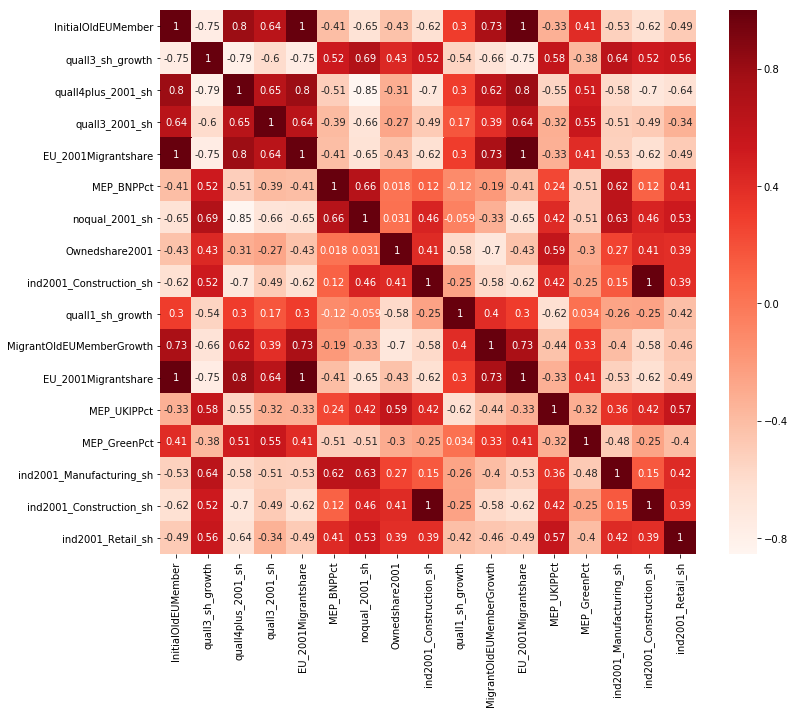

In [5]:
# Next, we generate correlation coefficients; we want to remove highly correlated features because highly correlated explanatory
# variables produce biased OLS models. We remove highly correlated features with low explanatory power first. 

PCOLS = data[['InitialOldEUMember', 'quall3_sh_growth', 'quall4plus_2001_sh', 'quall3_2001_sh', 'EU_2001Migrantshare', 
              'MEP_BNPPct', 'noqual_2001_sh', 'Ownedshare2001', 'ind2001_Construction_sh','quall1_sh_growth',
              'MigrantOldEUMemberGrowth', 'EU_2001Migrantshare', 'MEP_UKIPPct', 'MEP_GreenPct', 'ind2001_Manufacturing_sh',
              'ind2001_Construction_sh', 'ind2001_Retail_sh',]]

plt.figure(figsize=(12,10))
PCHM = PCOLS.corr()
sns.heatmap(PCHM, annot=True, cmap=plt.cm.Reds)
plt.show()

In [6]:
# After removing highly correlated features with low explanatory power, we are left with: 'MEP_UKIPPct', 'ind2001_Retail_sh', 
# 'ind2001_Manufacturing_sh', 'EU_2001Migrantshare','quall1_sh_growth', 'ind2001_Construction_sh'.

In [7]:
# We now fit our OLS model with features chosen using the filter method:

regr = linear_model.LinearRegression()


XPC7 = data[['MEP_UKIPPct', 'ind2001_Retail_sh', 'ind2001_Manufacturing_sh', 'EU_2001Migrantshare', 'quall1_sh_growth', 
             'ind2001_Construction_sh']]
YPC7 = data['Pct_Leave']
XPC7_train, XPC7_test, YPC7_train, YPC7_test = train_test_split(XPC7, YPC7, test_size=0.33, random_state=1)
PC7 = regr.fit(XPC7_train, YPC7_train)
PC7pred = PC7.predict(XPC7_test)

# Generate test and training SE and MSE to compare performance of models

PC7trainpred = PC7.predict(XPC7_train)
PC7train_se= (((PC7trainpred)-(YPC7_train))**2)
PC7train_mse= (PC7train_se.sum()/236)

PC7testpred = PC7.predict(XPC7_test)
PC7test_se= (((PC7testpred)-(YPC7_test))**2)
PC7test_mse= (PC7test_se.sum()/117)

# Convert to binary for confusion matrix/performance metrics

YPC7b_test=np.where(YPC7_test > 50, True, False)
YPC7b_pred=np.where(PC7testpred > 50, True, False)
YPC7bcnf_matrix = metrics.confusion_matrix(YPC7b_test, YPC7b_pred)

In [8]:
# Next, we generate an OLS model with features chosen through backwards elimination. 

BEX = data.drop(['Pct_Turnout','Votes_Cast', 'Valid_Votes', 'Remain', 'Leave','Pct_Remain',
                 'Pct_Leave','Pct_Rejected', 'outcome'], axis=1)
BEY = data['Pct_Leave']

# Adding constant column of ones, mandatory for sm.OLS model
BEX_1 = sm.add_constant(BEX)

# Fitting sm.OLS model
model = sm.OLS(BEY, BEX_1).fit()
pvalues = model.pvalues

# Filtering only statistically significant features
BErelevant_features = pvalues[pvalues<0.05]
print(BErelevant_features)

mean_hourly_pay_growth      6.863619e-03
MEP_ConPct                  1.737276e-02
MEP_UKIPPct                 5.998654e-20
MEP_GreenPct                1.776009e-09
MEP_BNPPct                  6.809928e-17
TREATED_WITHIN_62_DAYS      3.603619e-02
life_sat_mean               3.557576e-02
life_sat_cv                 8.303943e-03
noqual_2001_sh              1.820646e-02
quall1_2001_sh              1.820782e-02
quall2_2001_sh              1.820796e-02
quall3_2001_sh              1.820653e-02
quall4plus_2001_sh          1.820589e-02
ind2001_Mining_sh           1.069212e-03
ManufacturingShareGrowth    3.755258e-02
TransportShareGrowth        9.972395e-03
CouncilRented2001           2.013490e-02
dtype: float64


C:\Users\Altairhorace\Anaconda3\lib\site-packages\statsmodels\base\model.py:1100: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
C:\Users\Altairhorace\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\Altairhorace\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\Altairhorace\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


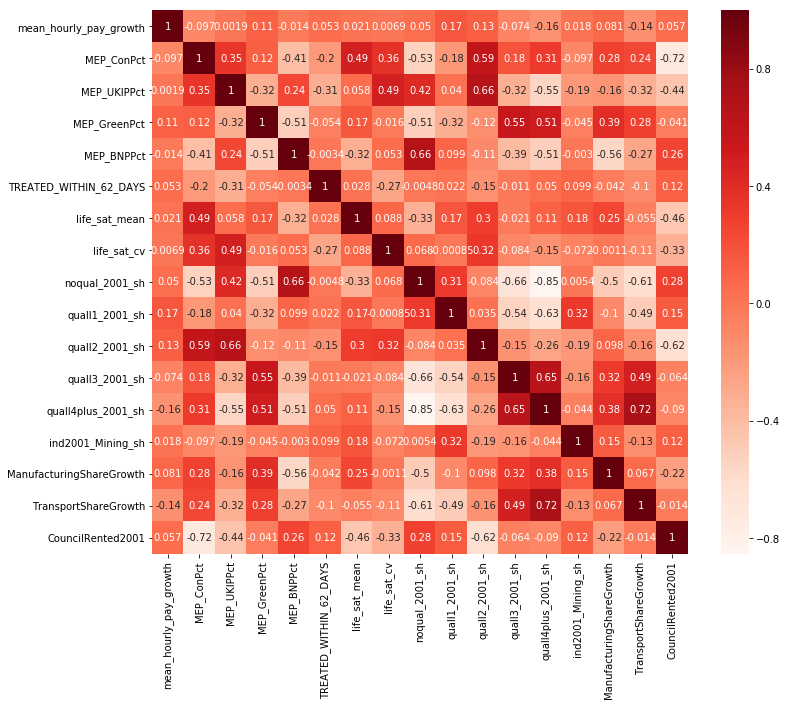

In [9]:
# Again, we generate a confusion heatmap to easily view correlations, which violate OLS assumptions

BEF = data[['mean_hourly_pay_growth', 'MEP_ConPct', 'MEP_UKIPPct', 'MEP_GreenPct', 'MEP_BNPPct', 'TREATED_WITHIN_62_DAYS',
           'life_sat_mean', 'life_sat_cv', 'noqual_2001_sh', 'quall1_2001_sh', 'quall2_2001_sh', 'quall3_2001_sh',
           'quall4plus_2001_sh', 'ind2001_Mining_sh', 'ManufacturingShareGrowth', 'TransportShareGrowth', 'CouncilRented2001']]

plt.figure(figsize=(12,10))
BEHM = BEF.corr()
sns.heatmap(BEHM, annot=True, cmap=plt.cm.Reds)
plt.show()

In [10]:
# After removing highly correlated features with low explanatory power, we are left with: 'mean_hourly_pay_growth', 
# 'MEP_UKIPPct', 'MEP_GreenPct', 'MEP_BNPPct', 'TREATED_WITHIN_62_DAYS', 'life_sat_mean', 'life_sat_cv',  'quall1_2001_sh',
# 'ind2001_Mining_sh', 'ManufacturingShareGrowth','TransportShareGrowth', 'CouncilRented2001'. We will now generate an OLS
# model using these features and generate measures of performance. 

BEX = data[['mean_hourly_pay_growth', 'MEP_UKIPPct', 'MEP_GreenPct', 'MEP_BNPPct', 'TREATED_WITHIN_62_DAYS',
           'life_sat_mean', 'life_sat_cv',  'quall1_2001_sh','ind2001_Mining_sh', 'ManufacturingShareGrowth',
           'TransportShareGrowth', 'CouncilRented2001']]
BEY = data[['Pct_Leave']]

BEX_train, BEX_test, BEY_train, BEY_test = train_test_split(BEX, BEY, test_size=0.33, random_state=1)
BE = regr.fit(BEX_train, BEY_train)
BEYpred = BE.predict(BEX_test)

# Calculate SE and MSE

BEYtrainpred = BE.predict(BEX_train)
BEtrain_se= (((BEYtrainpred)-(BEY_train))**2)
BEtrain_mse= (BEtrain_se.sum()/236)
BEtrain_mse

BEYtestpred = BE.predict(BEX_test)
BEtest_se= (((BEYtestpred)-(BEY_test))**2)
BEtest_mse= (BEtest_se.sum()/117)
BEtest_mse

# Changing to binary for confusion matrix and performance measures
BEYc_test=np.where(BEY_test > 50, True, False)
BEYc_pred=np.where(BEYpred > 50, True, False)
BEcnf_matrix = metrics.confusion_matrix(BEYc_test, BEYc_pred)

In [11]:
# Next, we generate an OLS model with features chosen recursive feature selection:

RFEX = data.drop(['Pct_Turnout','Votes_Cast', 'Valid_Votes', 'Remain', 'Leave','Pct_Remain','Pct_Leave','Pct_Rejected', 'outcome'], axis=1)
RFEY = data['Pct_Leave']

# Setting up array
nof_list=np.arange(1,86)            
high_score=0

# Variable to store the optimum features in above array
nof=0           
score_list =[]
for n in range(len(nof_list)):
    RFEX_train, RFEX_test, RFEY_train, RFEY_test = train_test_split(RFEX, RFEY, test_size = 0.3, random_state = 0)
    model = LinearRegression()
    rfe = RFE(model,nof_list[n])
    X_train_rfe = rfe.fit_transform(RFEX_train, RFEY_train)
    X_test_rfe = rfe.transform(RFEX_test)
    model.fit(X_train_rfe, RFEY_train)
    score = model.score(X_test_rfe, RFEY_test)
    score_list.append(score)
    if(score>high_score):
        high_score = score
        nof = nof_list[n]
print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))

Optimum number of features: 80
Score with 80 features: 0.968498


In [12]:
cols = list(RFEX.columns)
model = LinearRegression()

#Initializing recursive feature estimation model, where optimum number of features is informed by the above. 
rfe = RFE(model, 80)       

#Transforming data using recursive feature estimation
X_rfe = rfe.fit_transform(RFEX, RFEY) 

# Fitting the data to model and printing features
model.fit(X_rfe, RFEY)              
temp = pd.Series(rfe.support_,index = cols)
selected_features_rfe = temp[temp==True].index
print(selected_features_rfe)

Index(['EU75Leaveshare', 'pensionergrowth20012011', 'ResidentAge30to44share',
       'ResidentAge45to59share', 'ResidentAge60plusshare',
       'median_hourly_pay2005', 'median_hourly_pay_growth',
       'mean_hourly_pay_growth', 'EU_2001Migrantshare',
       'NONEU_2001Migrantshare', 'EU_Migrantgrowth', 'NONEU_Migrantgrowth',
       'unqualifiedsharechange', 'umemployment_rate_aps',
       'economic_activity_rate_aps2015', 'MEP_ConPct', 'MEP_LDPct',
       'MEP_UKIPPct', 'MEP_GreenPct', 'MEP_BNPPct',
       'Total_EconomyEU_dependence', 'TREATED_WITHIN_62_DAYS', 'life_sat_mean',
       'life_sat_cv', 'noqual_2001_sh', 'quall1_2001_sh', 'quall2_2001_sh',
       'quall3_2001_sh', 'quall4plus_2001_sh', 'noqual_sh_growth',
       'quall1_sh_growth', 'quall2_sh_growth', 'quall3_sh_growth',
       'quall4plus_sh_growth', 'ind2001_Agriculture_sh', 'ind2001_Mining_sh',
       'ind2001_Manufacturing_sh', 'ind2001_Construction_sh',
       'ind2001_Retail_sh', 'ind2001_HotelRestaurant_sh',
     

In [48]:
# Recursive feature selection tells us that the optimum model uses 80 features (listed above). Unlike the previous 2 OLS models,
# these features will not be screened to reduce model bias. This is because the recursive feature method is telling us the
# optimal model uses the above 80 features, so in this instance we will disregard concerns of high bias. 

RFX = data[['EU75Leaveshare', 'pensionergrowth20012011', 'ResidentAge30to44share',
       'ResidentAge45to59share', 'ResidentAge60plusshare',
       'median_hourly_pay2005', 'median_hourly_pay_growth',
       'mean_hourly_pay_growth', 'EU_2001Migrantshare',
       'NONEU_2001Migrantshare', 'EU_Migrantgrowth', 'NONEU_Migrantgrowth',
       'unqualifiedsharechange', 'umemployment_rate_aps',
       'economic_activity_rate_aps2015', 'MEP_ConPct', 'MEP_LDPct',
       'MEP_UKIPPct', 'MEP_GreenPct', 'MEP_BNPPct',
       'Total_EconomyEU_dependence', 'TREATED_WITHIN_62_DAYS', 'life_sat_mean',
       'life_sat_cv', 'noqual_2001_sh', 'quall1_2001_sh', 'quall2_2001_sh',
       'quall3_2001_sh', 'quall4plus_2001_sh', 'noqual_sh_growth',
       'quall1_sh_growth', 'quall2_sh_growth', 'quall3_sh_growth',
       'quall4plus_sh_growth', 'ind2001_Agriculture_sh', 'ind2001_Mining_sh',
       'ind2001_Manufacturing_sh', 'ind2001_Construction_sh',
       'ind2001_Retail_sh', 'ind2001_HotelRestaurant_sh',
       'ind2001_Transport_sh', 'ind2001_Finance_sh', 'AgricultureShareGrowth',
       'MiningShareGrowth', 'ManufacturingShareGrowth',
       'ConstructionShareGrowth', 'RetailShareGrowth',
       'HotelRestaurantShareGrowth', 'TransportShareGrowth',
       'FinanceShareGrowth', 'ResidentUnder30share', 'PrivateRentedshare2001',
       'Ownedshare2001', 'CouncilRented2001', 'CouncilRentedGrowth',
       'PrivateRentedGrowth', 'OwnedshareGrowth', 'PublicEmployment2014',
       'PublicEmployment2009', 'PublicEmploymentGrowth',
       'MigrantEUAccessionGrowth', 'MigrantOldEUMemberGrowth',
       'MigrantElsewhereGrowth', 'InitialEUAccession', 'InitialOldEUMember',
       'InitialElsewhere', 'rr_1', 'rr_2', 'rr_3', 'rr_4', 'rr_5', 'rr_7',
       'rr_8', 'rr_9', 'rr_10', 'rr_11', 'rr_12', 'cc_1', 'cc_3', 'cc_4']]
RFY = data[['Pct_Leave']]

RFX_train, RFX_test, RFY_train, RFY_test = train_test_split(RFX, RFY, test_size=0.33, random_state=1)
RF = regr.fit(RFX_train, RFY_train)
RFYpred = RF.predict(RFX_test)

# Calculate SE and MSE

RFYtrainpred = RF.predict(RFX_train)
RFYtrain_se= (((RFYtrainpred)-(RFY_train))**2)
RFYtrain_mse= (RFYtrain_se.sum()/236)
RFYtrain_mse

RFYtestpred = RF.predict(RFX_test)
RFYtest_se= (((RFYtestpred)-(RFY_test))**2)
RFYtest_mse= (RFYtest_se.sum()/117)
RFYtest_mse

# Changing to binary for confusion matrix and performance measures
RFYd_test=np.where(RFY_test > 50, True, False)
RFYd_pred=np.where(RFYpred > 50, True, False)
RFcnf_matrix = metrics.confusion_matrix(RFYd_test, RFYd_pred)

In [22]:
# We will try an embedded method of feature selection (regularisation); in this instance, we will be using
# Lasso regularisation. This involves the systematic shrinkage of OLS coefficients, which reduces the risk of overfitting
# but imposes higher bias. However, given the very large number of features, and very high risk of overfitting, this seems
# to be an acceptable trade-off. 

LX1 = data.drop(['Pct_Turnout','Votes_Cast', 'Valid_Votes', 'Remain', 'Leave','Pct_Remain','Pct_Leave','Pct_Rejected'], axis=1)
LY1 = data['Pct_Leave']

Lreg = LassoCV()
Lreg.fit(LX1, LY1)
print("Best score using built-in LassoCV: %f" %Lreg.score(LX1, LY1))
Lcoef = pd.Series(Lreg.coef_, index = LX1.columns)

print("Lasso picked " + str(sum(Lcoef != 0)) + " variables and eliminated the other " +  str(sum(Lcoef == 0)) +
      " variables; the variables it picked are:")
print("")

# Picking out best Lasso variables
imp_Lcoef = Lcoef.sort_values()
print(imp_Lcoef.head(6))
print("")
print(imp_Lcoef.tail(8))

Best score using built-in LassoCV: 0.938775
Lasso picked 12 variables and eliminated the other 75 variables; the variables it picked are:

median_hourly_pay2005    -0.981513
MEP_GreenPct             -0.746376
TREATED_WITHIN_62_DAYS   -0.041781
MEP_LDPct                -0.023797
MEP_ConPct               -0.006219
PublicEmployment2009      0.000000
dtype: float64

quall4plus_sh_growth             -0.000000
TotalImpactFLWAAYR                0.001122
self_employment_rate_aps          0.004665
MEP_Turnout                       0.037896
economic_activity_rate_aps2015    0.059973
umemployment_rate_aps             0.114250
MEP_UKIPPct                       0.765591
MEP_BNPPct                        2.724853
dtype: float64


C:\Users\Altairhorace\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


In [23]:
# We will now generate this model

LX = data[['median_hourly_pay2005', 'MEP_GreenPct', 'TREATED_WITHIN_62_DAYS', 'MEP_LDPct', 'MEP_ConPct',
           'TotalImpactFLWAAYR', 'self_employment_rate_aps', 'MEP_Turnout', 'economic_activity_rate_aps2015',
           'umemployment_rate_aps', 'MEP_UKIPPct', 'MEP_BNPPct']]

LY = data[['Pct_Leave']]


LX_train, LX_test, LY_train, LY_test = train_test_split(LX, LY, test_size=0.33, random_state=1)
L = regr.fit(LX_train, LY_train)

# Calculate SE and MSE

Ltrainpred = L.predict(LX_train)
Ltrain_se= (((Ltrainpred)-(LY_train))**2)
Ltrain_mse= (Ltrain_se.sum()/236)

Ltestpred = L.predict(LX_test)
Ltest_se= (((Ltestpred)-(LY_test))**2)
Ltest_mse= (Ltest_se.sum()/117)


# Changing to binary for confusion matrix and performance measures
Le_test=np.where(LY_test > 50, True, False)
Le_pred=np.where(Ltestpred > 50, True, False)
LYcnf_matrix = metrics.confusion_matrix(Le_test, Le_pred)

In [24]:
# We will now estimate models using logistic regression to see if this improves performace. We will produce four models using
# the same features as the models used above, therefore we will not repeat any of the feature selection methods. It is worth
# noting that we will no longer be able to use MSE as a performance metric, and will instead be using area under curve (AUC)
# value. 

In [25]:
# First, we generate a logistic regression model with features chosen through the filter method:

LR7X = data[['MEP_UKIPPct', 'ind2001_Retail_sh', 'ind2001_Manufacturing_sh', 'EU_2001Migrantshare', 'quall1_sh_growth',
             'ind2001_Construction_sh']]
LR7Y = data['outcome']

LR7X_train, LR7X_test, LR7Y_train, LR7Y_test = train_test_split(LR7X, LR7Y, test_size=0.33,random_state=0)
logreg = LogisticRegression()
logreg.fit(LR7X_train, LR7Y_train)
LR7Y_pred=logreg.predict(LR7X_test)

# Generating confusion matrix and AUC
LR7cnf_matrix = metrics.confusion_matrix(LR7Y_test, LR7Y_pred)
LR7Y_pred_proba = logreg.predict_proba(LR7X_test)[::,1]
LR7fpr, LR7tpr, _ = metrics.roc_curve(LR7Y_test,  LR7Y_pred_proba)
LR7auc = metrics.roc_auc_score(LR7Y_test, LR7Y_pred_proba)

C:\Users\Altairhorace\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [26]:
# Next, we generate a logistic regression model with features chosen through backwards elimination:

LRBEX = data[['mean_hourly_pay_growth', 'MEP_UKIPPct', 'MEP_GreenPct', 'MEP_BNPPct', 'TREATED_WITHIN_62_DAYS',
           'life_sat_mean', 'life_sat_cv',  'quall1_2001_sh','ind2001_Mining_sh', 'ManufacturingShareGrowth',
           'TransportShareGrowth', 'CouncilRented2001']]
LRBEY = data[['outcome']]

LRBEX_train, LRBEX_test, LRBEY_train, LRBEY_test = train_test_split(LRBEX, LRBEY, test_size=0.33,random_state=0)
logreg.fit(LRBEX_train, LRBEY_train)
LRBEY_pred=logreg.predict(LRBEX_test)


# Generating confusion matrix and AUC
LRBEcnf_matrix = metrics.confusion_matrix(LRBEY_test, LRBEY_pred)
LRBEY_pred_proba = logreg.predict_proba(LRBEX_test)[::,1]
LRBEfpr, LRBEtpr, _ = metrics.roc_curve(LRBEY_test,  LRBEY_pred_proba)
LRBEauc = metrics.roc_auc_score(LRBEY_test, LRBEY_pred_proba)

C:\Users\Altairhorace\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Altairhorace\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [27]:
# Next, we generate a logistic regression model with features chosen through  recursive selection:

LRRFX = data[['EU75Leaveshare', 'pensionergrowth20012011', 'ResidentAge30to44share',
       'ResidentAge45to59share', 'ResidentAge60plusshare',
       'median_hourly_pay2005', 'median_hourly_pay_growth',
       'mean_hourly_pay_growth', 'EU_2001Migrantshare',
       'NONEU_2001Migrantshare', 'EU_Migrantgrowth', 'NONEU_Migrantgrowth',
       'unqualifiedsharechange', 'umemployment_rate_aps',
       'economic_activity_rate_aps2015', 'MEP_ConPct', 'MEP_LDPct',
       'MEP_UKIPPct', 'MEP_GreenPct', 'MEP_BNPPct',
       'Total_EconomyEU_dependence', 'TREATED_WITHIN_62_DAYS', 'life_sat_mean',
       'life_sat_cv', 'noqual_2001_sh', 'quall1_2001_sh', 'quall2_2001_sh',
       'quall3_2001_sh', 'quall4plus_2001_sh', 'noqual_sh_growth',
       'quall1_sh_growth', 'quall2_sh_growth', 'quall3_sh_growth',
       'quall4plus_sh_growth', 'ind2001_Agriculture_sh', 'ind2001_Mining_sh',
       'ind2001_Manufacturing_sh', 'ind2001_Construction_sh',
       'ind2001_Retail_sh', 'ind2001_HotelRestaurant_sh',
       'ind2001_Transport_sh', 'ind2001_Finance_sh', 'AgricultureShareGrowth',
       'MiningShareGrowth', 'ManufacturingShareGrowth',
       'ConstructionShareGrowth', 'RetailShareGrowth',
       'HotelRestaurantShareGrowth', 'TransportShareGrowth',
       'FinanceShareGrowth', 'ResidentUnder30share', 'PrivateRentedshare2001',
       'Ownedshare2001', 'CouncilRented2001', 'CouncilRentedGrowth',
       'PrivateRentedGrowth', 'OwnedshareGrowth', 'PublicEmployment2014',
       'PublicEmployment2009', 'PublicEmploymentGrowth',
       'MigrantEUAccessionGrowth', 'MigrantOldEUMemberGrowth',
       'MigrantElsewhereGrowth', 'InitialEUAccession', 'InitialOldEUMember',
       'InitialElsewhere', 'rr_1', 'rr_2', 'rr_3', 'rr_4', 'rr_5', 'rr_7',
       'rr_8', 'rr_9', 'rr_10', 'rr_11', 'rr_12', 'cc_1', 'cc_3', 'cc_4']]

LRRFY = data[['outcome']]

LRRFX_train, LRRFX_test, LRRFY_train, LRRFY_test = train_test_split(LRRFX, LRRFY, test_size=0.33,random_state=0)
logreg.fit(LRRFX_train, LRRFY_train)
LRRFY_pred=logreg.predict(LRRFX_test)

# Generating confusion matrix and AUC
LRRFcnf_matrix = metrics.confusion_matrix(LRRFY_test, LRRFY_pred)
LRRFY_pred_proba = logreg.predict_proba(LRRFX_test)[::,1]
LRRFfpr, LRRFtpr, _ = metrics.roc_curve(LRRFY_test,  LRRFY_pred_proba)
LRRFauc = metrics.roc_auc_score(LRRFY_test, LRRFY_pred_proba)

C:\Users\Altairhorace\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Altairhorace\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [28]:
# Next, we generate a logistic regression model with features chosen through Lasso regularisation:

LRLX = data[['median_hourly_pay2005', 'MEP_GreenPct', 'TREATED_WITHIN_62_DAYS', 'MEP_LDPct', 'MEP_ConPct',
           'TotalImpactFLWAAYR', 'self_employment_rate_aps', 'MEP_Turnout', 'economic_activity_rate_aps2015',
           'umemployment_rate_aps', 'MEP_UKIPPct', 'MEP_BNPPct']]

LRLY = data[['outcome']]

LRLX_train, LRLX_test, LRLY_train, LRLY_test = train_test_split(LRLX, LRLY, test_size=0.33,random_state=0)
logreg.fit(LRLX_train, LRLY_train)
LRLY_pred=logreg.predict(LRLX_test)

# Generating confusion matrix and AUC
LRLcnf_matrix = metrics.confusion_matrix(LRLY_test, LRLY_pred)
LRLY_pred_proba = logreg.predict_proba(LRLX_test)[::,1]
LRLfpr, LRLtpr, _ = metrics.roc_curve(LRLY_test,  LRLY_pred_proba)
LRLauc = metrics.roc_auc_score(LRLY_test, LRLY_pred_proba)

C:\Users\Altairhorace\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Altairhorace\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [29]:
# We will now generate random forest models to check if these perform any better. We will be using the RandomForestClassifier
# and the AdaBoostClassieir. For the RandomForestClassifier models, we will produce 2: (a) will select features automactially,
# and we will only adjust function parameters, and (b) will select only the most important features.

# RandomForestClassifier (a) model:

RFXa = data.drop(['Pct_Turnout','Votes_Cast', 'Valid_Votes', 'Remain', 'outcome',
                  'Leave','Pct_Remain','Pct_Leave','Pct_Rejected'], axis=1)
RFYa = data['outcome']
RFXa_train, RFXa_test, RFYa_train, RFYa_test = train_test_split(RFXa, RFYa, test_size = .33, random_state=0)

# Training/fitting the model
RFa = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=8, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=2, n_jobs=None,
            oob_score=None, random_state=1, verbose=0,
            warm_start=False)

# NB: information gains appear to be exhausted after max_depth>8; we have tried values from 0 to 30, and precision/accuracy/
# recall scores are not affected beyong max_depth = 8. 

RFa.fit(RFXa_train, RFYa_train)  
RFYa_pred = RFa.predict(RFXa_test) 

# Generating confusion matrix and AUC
RFacnf_matrix = metrics.confusion_matrix(RFYa_test, RFYa_pred)
RFYa_pred_proba = RFa.predict_proba(RFXa_test)[::,1]
RFafpr, RFatpr, _ = metrics.roc_curve(RFYa_test,  RFYa_pred_proba)
RFaauc = metrics.roc_auc_score(RFYa_test, RFYa_pred_proba)

In [30]:
# RandomForestClassifier (b) model; most important features only:

# Finding important features
feature_importances = pd.DataFrame(RFa.feature_importances_,
                                   index = RFXa_train.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)

feature_importances.head(20)

,importance
MEP_UKIPPct,0.379231
quall4plus_2001_sh,0.195039
EU75Leaveshare,0.110084
MEP_GreenPct,0.056168
MEP_LabPct,0.051997
noqual_2001_sh,0.033047
InitialEUAccession,0.032465
quall1_sh_growth,0.030109
quall1_2001_sh,0.028517
PrivateRentedGrowth,0.026404


In [31]:
# We now generate a random forest (b) based on the above features with non-zero importance:

RFXb = data[['MEP_UKIPPct', 'quall4plus_2001_sh', 'EU75Leaveshare', 'MEP_GreenPct', 'MEP_LabPct', 'noqual_2001_sh',
            'InitialEUAccession', 'quall1_sh_growth', 'quall1_2001_sh', 'PrivateRentedGrowth', 'CouncilRented2001',
            'quall2_2001_sh', 'ind2001_Mining_sh', 'unqualifiedsharechange', 'mean_hourly_pay_growth', 'RetailShareGrowth',
            'TransportShareGrowth', 'TotalImpactFLWAAYR']]  
RFYb = data['outcome']                                       

RFXb_train, RFXb_test, RFYb_train, RFYb_test = train_test_split(RFXb, RFYb, test_size=0.70, random_state=5)

RFb = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=100, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=2, n_jobs=None,
            oob_score=None, random_state=1, verbose=0,
            warm_start=False)

RFb.fit(RFXb_train, RFYb_train)  
RFYb_pred = RFb.predict(RFXb_test)

# Generating confusion matrix and AUC
RFbcnf_matrix = metrics.confusion_matrix(RFYb_test, RFYb_pred)
RFYb_pred_proba = RFb.predict_proba(RFXb_test)[::,1]
RFbfpr, RFbtpr, _ = metrics.roc_curve(RFYb_test,  RFYb_pred_proba)
RFbauc = metrics.roc_auc_score(RFYb_test, RFYb_pred_proba)

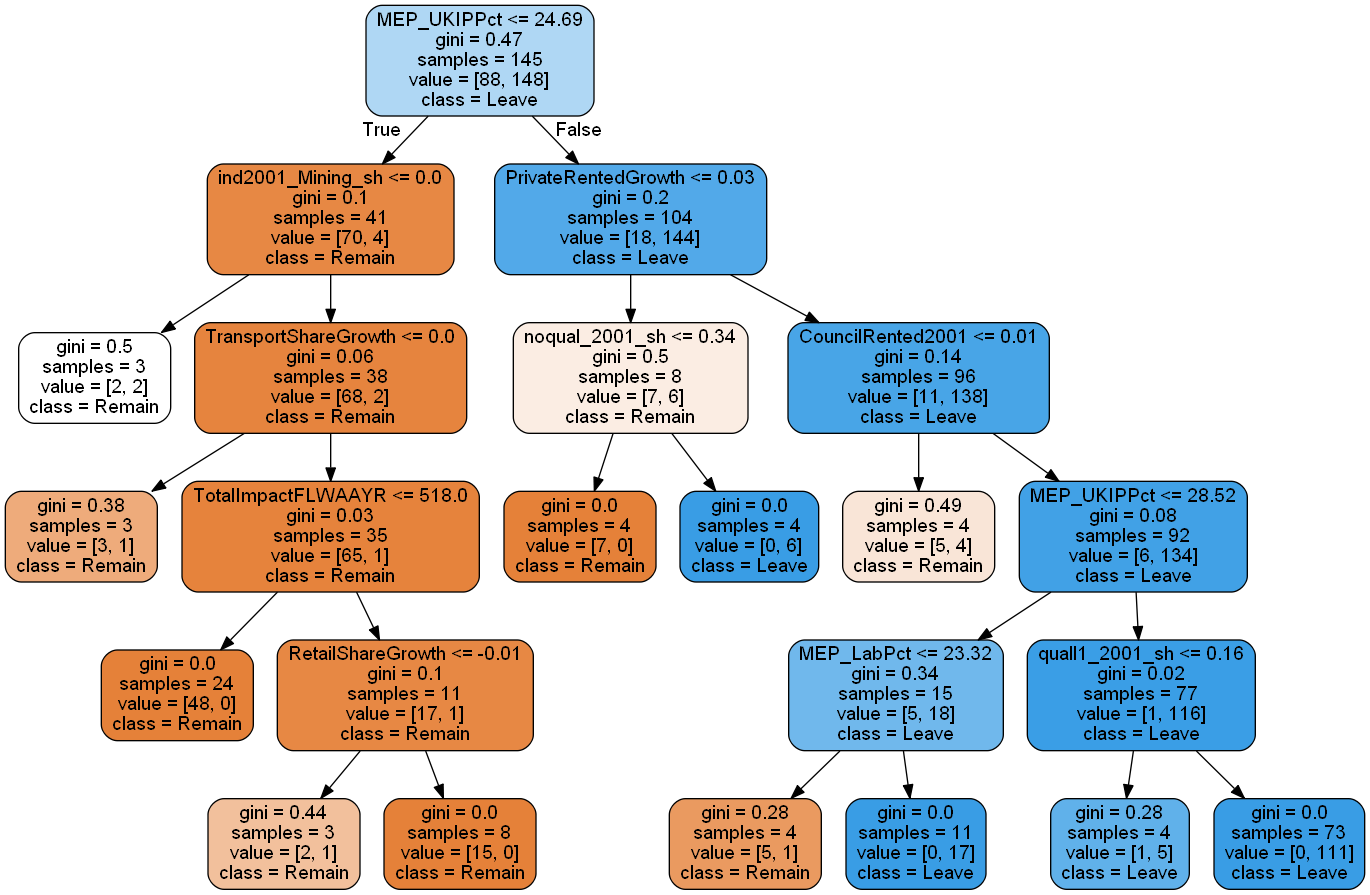

In [32]:
# Visualisation of the RF
# sys and pydotplus may need to be installed to Anaconda 

tree=RFa.estimators_[1]
from sklearn.tree import export_graphviz
export_graphviz(tree, out_file='tree.dot', 
                feature_names = RFXa_train.columns.values.tolist(),
                class_names = ["Remain", "Leave"],
                rounded = True, proportion = False, 
                precision = 2, filled = True)
import pydotplus
pydot_graph = pydotplus.graph_from_dot_file("tree.dot")
from IPython.display import Image
Image(pydot_graph.create_png())

In [33]:
# We will now generate a model using AdaBoostClassifier:
# By default an AdaBoostClassifier is boosting a decision tree classifier

RFABCX = data.drop(['Pct_Turnout','Votes_Cast', 'Valid_Votes', 'Remain', 'outcome',
                  'Leave','Pct_Remain','Pct_Leave','Pct_Rejected'], axis=1)
RFABCY = data['outcome']
RFABCX_train, RFABCX_test, RFABCY_train, RFABCY_test = train_test_split(RFABCX, RFABCY, test_size = .33, random_state=0)

ABC = AdaBoostClassifier(base_estimator=None, n_estimators=1000, learning_rate=1.0, algorithm='SAMME.R', random_state=None)
RFABC = ABC.fit(RFABCX_train, RFABCY_train)
RFABCY_pred = ABC.predict(RFABCX_test)

# Printing important features, so that we know what the model is using: 

ABCfeature_importances = pd.DataFrame(ABC.feature_importances_,
                                   index = RFABCX_train.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)

ABCfeature_importances.head(40)

,importance
MEP_UKIPPct,0.142
unqualifiedsharechange,0.081
MEP_BNPPct,0.074
MEP_GreenPct,0.049
life_sat_cv,0.046
ind2001_Construction_sh,0.040
noqual_2001_sh,0.039
quall3_2001_sh,0.030
quall4plus_2001_sh,0.030
FinanceShareGrowth,0.030


In [34]:
# Generating confusion matrix and AUC
RFABCcnf_matrix = metrics.confusion_matrix(RFABCY_test, RFABCY_pred)
RFABCY_pred_proba = ABC.predict_proba(RFABCX_test)[::,1]
RFABCfpr, RFABCtpr, _ = metrics.roc_curve(RFABCY_test,  RFABCY_pred_proba)
RFABCauc = metrics.roc_auc_score(RFABCY_test, RFABCY_pred_proba)

OLS, filter method
Confusion matrix:
[[29  8]
 [ 6 74]]
Accuracy: 0.8803418803418803
Precision: 0.9024390243902439
Recall: 0.925
Training MSE: 13.275278941877088
Test MSE: 13.662073668320055

OLS, backwards elimination
Confusion matrix:
[[31  6]
 [ 4 76]]
Accuracy: 0.9145299145299145
Precision: 0.926829268292683
Recall: 0.95
Training MSE: Pct_Leave    6.078881
dtype: float64
Test MSE: Pct_Leave    9.08286
dtype: float64

OLS, recursive feature elimination
Confusion matrix:
[[34  3]
 [ 3 77]]
Accuracy: 0.9487179487179487
Precision: 0.9625
Recall: 0.9625
Training MSE: Pct_Leave    1.707548
dtype: float64
Test MSE: Pct_Leave    5.16494
dtype: float64

OLS, Lasso regularisation
Confusion matrix:
[[33  4]
 [ 4 76]]
Accuracy: 0.9316239316239316
Precision: 0.95
Recall: 0.95
Training MSE: Pct_Leave    6.060954
dtype: float64
Test MSE: Pct_Leave    7.61429
dtype: float64

Logistic regression, filter method
Confusion matrix:
[[23 14]
 [ 1 79]]
Accuracy: 0.8717948717948718
Precision: 0.8494623655

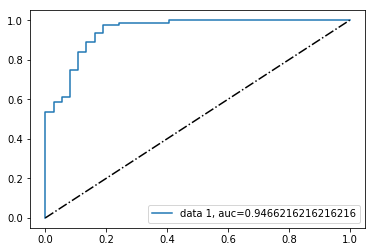

Logistic regression, backwards elimination
Confusion matrix:
[[34  3]
 [ 5 75]]
Accuracy: 0.9316239316239316
Precision: 0.9615384615384616
Recall: 0.9375
0.9790540540540541



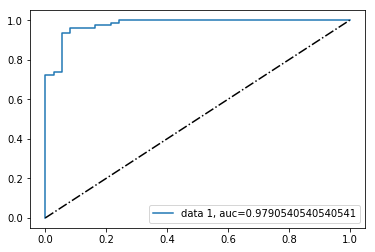

Logistic regression, recursive feature selection
Confusion matrix:
[[33  4]
 [ 4 76]]
Accuracy: 0.9316239316239316
Precision: 0.95
Recall: 0.95
0.9864864864864865



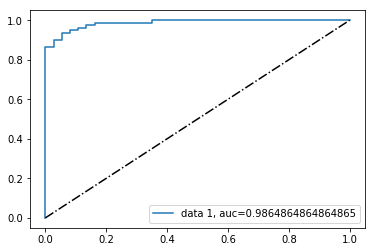

Logistic regression, Lasso regularisation
Confusion matrix:
[[34  3]
 [ 4 76]]
Accuracy: 0.9401709401709402
Precision: 0.9620253164556962
Recall: 0.95
0.9824324324324325



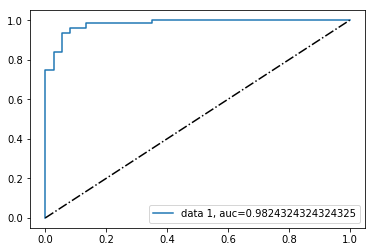

Random forrest (a)
Confusion matrix:
[[33  4]
 [ 4 76]]
Accuracy: 0.9316239316239316
Precision: 0.95
Recall: 0.95
0.9582770270270271



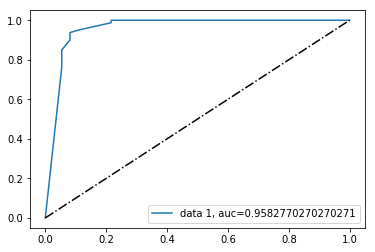

Random forrest (b)
Confusion matrix:
[[ 68  14]
 [ 12 154]]
Accuracy: 0.8951612903225806
Precision: 0.9166666666666666
Recall: 0.927710843373494
0.9264252130473112



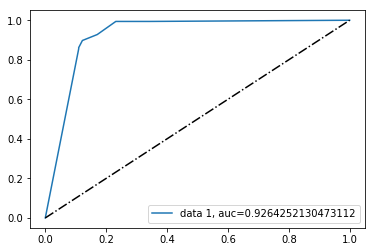

AdaBoostClassifier
Confusion matrix:
[[35  2]
 [ 4 76]]
Accuracy: 0.9487179487179487
Precision: 0.9743589743589743
Recall: 0.95
0.9898648648648649



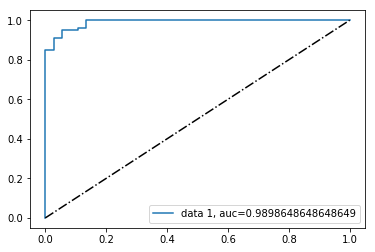

In [49]:
# Summary of all results: 

# OLS, filter method
print("OLS, filter method")
print("Confusion matrix:")
print(YPC7bcnf_matrix)
print("Accuracy:",metrics.accuracy_score(YPC7b_test, YPC7b_pred))
print("Precision:",metrics.precision_score(YPC7b_test, YPC7b_pred))
print("Recall:",metrics.recall_score(YPC7b_test, YPC7b_pred))
print("Training MSE:", PC7train_mse)
print("Test MSE:", PC7test_mse)
print("")

# OLS, backwards elimination
print("OLS, backwards elimination")
print("Confusion matrix:")
print(BEcnf_matrix)
print("Accuracy:",metrics.accuracy_score(BEYc_test, BEYc_pred))
print("Precision:",metrics.precision_score(BEYc_test, BEYc_pred))
print("Recall:",metrics.recall_score(BEYc_test, BEYc_pred))
print("Training MSE:", BEtrain_mse)
print("Test MSE:", BEtest_mse)
print("")

# OLS, recursive feature selection
print("OLS, recursive feature elimination")
print("Confusion matrix:")
print(RFcnf_matrix)
print("Accuracy:",metrics.accuracy_score(RFYd_test, RFYd_pred))
print("Precision:",metrics.precision_score(RFYd_test, RFYd_pred))
print("Recall:",metrics.recall_score(RFYd_test, RFYd_pred))
print("Training MSE:", RFYtrain_mse)
print("Test MSE:", RFYtest_mse)
print("")

# OLS, Lasso regulairsation
print("OLS, Lasso regularisation")
print("Confusion matrix:")
print(LYcnf_matrix)
print("Accuracy:",metrics.accuracy_score(Le_test, Le_pred))
print("Precision:",metrics.precision_score(Le_test, Le_pred))
print("Recall:",metrics.recall_score(Le_test, Le_pred))
print("Training MSE:", Ltrain_mse)
print("Test MSE:", Ltest_mse)
print("")

# Logistic regression, filter method
print("Logistic regression, filter method")
print("Confusion matrix:")
print(LR7cnf_matrix)
print("Accuracy:",metrics.accuracy_score(LR7Y_test, LR7Y_pred))
print("Precision:",metrics.precision_score(LR7Y_test, LR7Y_pred))
print("Recall:",metrics.recall_score(LR7Y_test, LR7Y_pred))
print(LRLauc)
print("")
plt.plot(LR7fpr,LR7tpr,label="data 1, auc="+str(LR7auc))
plt.plot([0, 1], [0, 1],'k-.')
plt.legend(loc=4)
plt.show()

# Logistic regression, backwards elimination
print("Logistic regression, backwards elimination")
print("Confusion matrix:")
print(LRBEcnf_matrix)
print("Accuracy:",metrics.accuracy_score(LRBEY_test, LRBEY_pred))
print("Precision:",metrics.precision_score(LRBEY_test, LRBEY_pred))
print("Recall:",metrics.recall_score(LRBEY_test, LRBEY_pred))
print(LRBEauc)
print("")
plt.plot(LRBEfpr,LRBEtpr,label="data 1, auc="+str(LRBEauc))
plt.plot([0, 1], [0, 1],'k-.')
plt.legend(loc=4)
plt.show()

# Logistic regression, recursive feature selection
print("Logistic regression, recursive feature selection")
print("Confusion matrix:")
print(LRRFcnf_matrix)
print("Accuracy:",metrics.accuracy_score(LRRFY_test, LRRFY_pred))
print("Precision:",metrics.precision_score(LRRFY_test, LRRFY_pred))
print("Recall:",metrics.recall_score(LRRFY_test, LRRFY_pred))
print(LRRFauc)
print("")
plt.plot(LRRFfpr,LRRFtpr,label="data 1, auc="+str(LRRFauc))
plt.plot([0, 1], [0, 1],'k-.')
plt.legend(loc=4)
plt.show()

# Logistic regression, Lasso regularisation
print("Logistic regression, Lasso regularisation")
print("Confusion matrix:")
print(LRLcnf_matrix)
print("Accuracy:",metrics.accuracy_score(LRLY_test, LRLY_pred))
print("Precision:",metrics.precision_score(LRLY_test, LRLY_pred))
print("Recall:",metrics.recall_score(LRLY_test, LRLY_pred))
print(LRLauc)
print("")
plt.plot(LRLfpr,LRLtpr,label="data 1, auc="+str(LRLauc))
plt.plot([0, 1], [0, 1],'k-.')
plt.legend(loc=4)
plt.show()

# Random forest (a), automatic feature selection
print("Random forrest (a)")
print("Confusion matrix:")
print(RFacnf_matrix)
print("Accuracy:", metrics.accuracy_score(RFYa_test, RFYa_pred))
print("Precision:",metrics.precision_score(RFYa_test, RFYa_pred))
print("Recall:",metrics.recall_score(RFYa_test, RFYa_pred))
print(RFaauc)
print("")
plt.plot(RFafpr,RFatpr,label="data 1, auc="+str(RFaauc))
plt.plot([0, 1], [0, 1],'k-.')
plt.legend(loc=4)
plt.show()

# Random forst (b), most important features only
print("Random forrest (b)")
print("Confusion matrix:")
print(metrics.confusion_matrix(RFYb_test, RFYb_pred))
print("Accuracy:", metrics.accuracy_score(RFYb_test, RFYb_pred))
print("Precision:",metrics.precision_score(RFYb_test, RFYb_pred))
print("Recall:",metrics.recall_score(RFYb_test, RFYb_pred))
print(RFbauc)
print("")
plt.plot(RFbfpr,RFbtpr,label="data 1, auc="+str(RFbauc))
plt.plot([0, 1], [0, 1],'k-.')
plt.legend(loc=4)
plt.show()

# AdaBoostClassifier
print("AdaBoostClassifier")
print("Confusion matrix:")
print(metrics.confusion_matrix(RFABCY_test, RFABCY_pred))
print("Accuracy:", metrics.accuracy_score(RFABCY_test, RFABCY_pred))
print("Precision:",metrics.precision_score(RFABCY_test, RFABCY_pred))
print("Recall:",metrics.recall_score(RFABCY_test, RFABCY_pred))
print(RFABCauc)
print("")
plt.plot(RFABCfpr,RFABCtpr,label="data 1, auc="+str(RFABCauc))
plt.plot([0, 1], [0, 1],'k-.')
plt.legend(loc=4)
plt.show()

In [50]:
# Performance evaluation:

# OLS performance depends entirely on choice of features; best performance when features chosen through backwards elimination 
# or Lasso regularisation. Fitting the same models using logistic regression generally improves performance, but relative 
# performance does not change. The model with features chosen through recursive selection is the exception, which goes from 
# being the best to worst performing model when estimated with OLS or logistic regression. Random forest model performs 
# similar (slightly worse) to the better performing logistic regression models. However, when random forests are generated 
# using only the most important features performance is much worse; the reason for this is unclear, may be due to high feature
# to observation ratio. Additionally, when AdaBoostClassifier is used instead performance is much better.AdaBoostClassifier 
# and OLS with features chosen by recursive selection produce best performing models, but AdaBoostClassifier model uses far 
# fewer features. 80 features seems very high given there are little over 300 estimates, but overfitting ought to manifest 
# itself in poorer performance metrics, which has not happened. Accuracy scores of best performing models all around 0.94, 
# meaning any model would have a fairly large margin of error if used to predict the outcome of another referendum. However, 
# the AdaBoostClassifier model, and logistic regression models with features chosen using backwards elimination and lasso 
# regularisation, are accurate enough that they could probably give a reasonable indication. 

In [51]:
# Discussion:

# Given this is a classification problem, logistic regression models probably work better than OLS models because logistic 
# regression is better suited for classification; OLS may be wasteful of data in that it is trying to calculate the percentage 
# of leave vote, while logistic regression is just concerned with binary classification. 

# Lasso regularisation probably works well because it shrinks coefficients with less explanatory power, and gives more weight 
# to the remaining features. Given the nature of this data set (lots of features, relatively few observations), it is 
# unsurprising a model generated by reducing noise performs well. 

# It is interesting that a model with features chosen through recursive selection performs very well when generated using OLS 
# but poorly when generated using logistic regression. We are unsure why this is the case.

# AdaBoostClassifier produces a much better classification model than RandomForestClassifier. The key difference is that 
# AdaBoost builds stronger classifiers by combining multiple, poorly performing classifiers, which is probably the reason 
# AdaBoost performs so much better. Normal Random Forest classification, in this case, might not be performing as well because 
# there is too much noise; using AdaBoost solves this problem.

# AdaBoostClassifier produces the best model by far, and lasso regularisation also performs very well. Again, this is probably 
# due to the high dimensional nature of this dataset: there is lots of noise, and these methods systematically reduce noise and 
# assign greater weights to relevant variables, giving them better predictive power and accuracy. Perhaps AdaBoost performs 
# better than Lasso regularisation because it does not shrink coefficients to zero, so it is able to reduce noise without being 
# wasteful of data.

In [52]:
# Conclusion: For the reasons discussed above, it is probably best to use something like AdaBoostClassifier when analysing 
# small high-dimensional datasets: this method reduces the amount of noise in the model, therefore reducing variance, but it 
# is not wasteful of this data, instead combining irrelevant features; we have not found another method that does this. As
# further evidence of this, the second best performing model uses Lasso regularisation, which reduces irrelevant coefficients
# to zero; the difference in performance between the two models is likely due to Lasso wasting 'noise data' on the one hand,
# and AdaBoostClassifier collating it on the other. 